## Image classification 

predicting poisonous mushroom given its appearance.

Baseline accuracy: 50%

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [97]:
directory = "/Users/laurameyer/code/DSP-Tan/mushroom_learning/raw_data/mushroom_poison"

In [98]:
def get_images_directory(directory):
    data_dir = pathlib.Path(directory)
    return data_dir

In [99]:
data_dir = get_images_directory(directory)
data_dir

PosixPath('/Users/laurameyer/code/DSP-Tan/mushroom_learning/raw_data/mushroom_poison')

In [100]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

9552


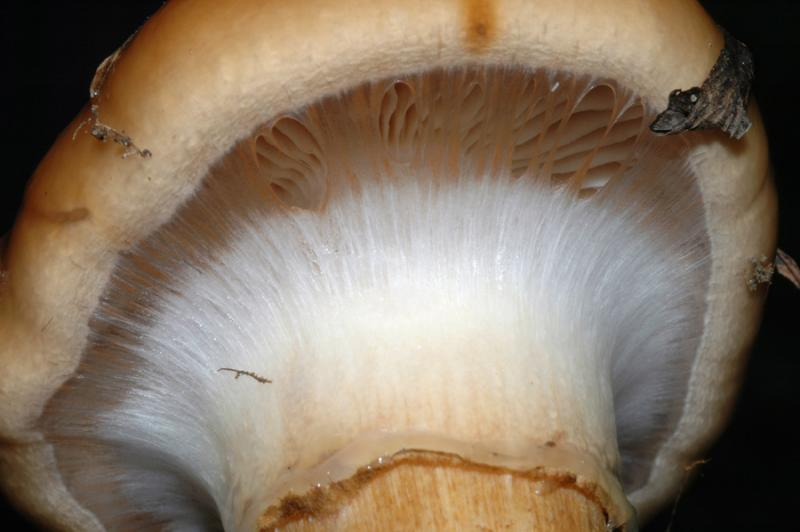

In [101]:
mushrooms = list(data_dir.glob('poison/*'))
PIL.Image.open(str(mushrooms[0]))

In [102]:
img_height = 224
img_width = 224
batch_size = 32

In [128]:
def load_training_data():

    return tf.keras.utils.image_dataset_from_directory(
      data_dir,
      labels='inferred',
      label_mode='binary', 
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size
    )

train_ds = load_training_data()
type(train_ds)

Found 11703 files belonging to 2 classes.
Using 9363 files for training.


tensorflow.python.data.ops.dataset_ops.BatchDataset

In [129]:
def load_validation_data():
    return tf.keras.utils.image_dataset_from_directory(
      data_dir,
      labels='inferred', 
      label_mode='binary', 
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size
    )

val_ds = load_validation_data()

Found 11703 files belonging to 2 classes.


In [112]:
class_names = train_ds.class_names
class_names

['edable', 'poison']

In [170]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 1)


## Check which jpeg image is corrupted and delete it

In [96]:
from struct import unpack
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

In [49]:
normalization_layer = layers.Rescaling(1./255)

In [51]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [54]:
type(normalized_ds)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow import keras

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [138]:
num_classes

2

In [140]:
from keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [198]:
opt = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [199]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2, restore_best_weights=True)

epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es], 
  verbose=1
)

Epoch 1/10
293/293 [==============================] - 578s 2s/step - loss: 0.6114 - accuracy: 0.6548 - val_loss: 0.6088 - val_accuracy: 0.6655
Epoch 2/10
293/293 [==============================] - 663s 2s/step - loss: 0.6043 - accuracy: 0.6697 - val_loss: 0.6074 - val_accuracy: 0.6662
Epoch 3/10
293/293 [==============================] - 590s 2s/step - loss: 0.5996 - accuracy: 0.6687 - val_loss: 0.6164 - val_accuracy: 0.6538
Epoch 4/10
293/293 [==============================] - 513s 2s/step - loss: 0.5996 - accuracy: 0.6683 - val_loss: 0.6079 - val_accuracy: 0.6645


[0.6548115015029907, 0.6696571707725525, 0.6686959266662598, 0.6682687401771545]
[0.6654704213142395, 0.6662394404411316, 0.653764009475708, 0.6645304560661316]
range(0, 4)


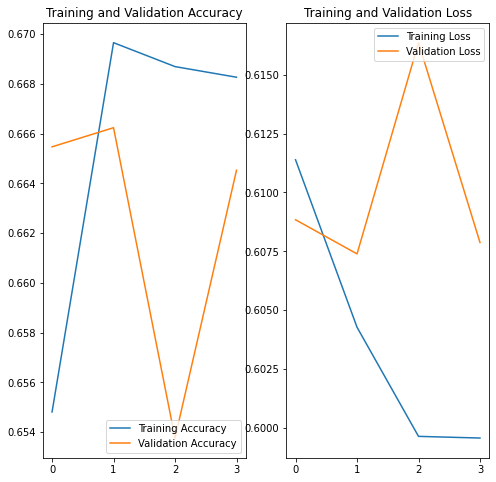

In [201]:
acc = history.history['accuracy']
print(acc)
val_acc = history.history['val_accuracy']
print(val_acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(0,4)
print(epochs_range)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [160]:
img = tf.keras.utils.load_img(
    "/Users/laurameyer/Desktop/poisonous-white-mushrooms.jpg", target_size=(img_height, img_width)
)
print(img)

<PIL.Image.Image image mode=RGB size=224x224 at 0x155D09E20>


In [164]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[102., 137., 107.],
         [ 80., 114.,  89.],
         [103., 136., 117.],
         ...,
         [ 85., 119., 103.],
         [ 97., 123., 112.],
         [ 88., 114., 103.]],

        [[109., 144., 111.],
         [ 87., 122.,  90.],
         [ 93., 127., 102.],
         ...,
         [ 67.,  99.,  84.],
         [ 82., 110.,  98.],
         [ 95., 123., 111.]],

        [[ 81., 118.,  77.],
         [ 84., 120.,  84.],
         [ 72., 107.,  75.],
         ...,
         [ 83., 112.,  94.],
         [ 89., 119., 107.],
         [ 67.,  97.,  85.]],

        ...,

        [[  7.,  27.,   0.],
         [ 17.,  31.,  18.],
         [ 19.,  31.,  21.],
         ...,
         [ 23.,  53.,   3.],
         [ 31.,  64.,  21.],
         [ 47.,  83.,  39.]],

        [[ 44.,  64.,  39.],
         [ 40.,  54.,  37.],
         [ 17.,  27.,  18.],
         ...,
         [ 42.,  76.,  25.],
         [ 39.,  75.,  29.],
         

In [202]:
prediction = model.predict(img_array)
print(prediction)
classif = int(prediction > .5)
print(classif)

print(f"This image most likely belongs to {class_names[classif]} with a score of: {prediction[0][0]:.2f}")

[[0.49891385]]
0
This image most likely belongs to edable with a score of: 0.50


In [204]:
model.save("../our_first_model")


INFO:tensorflow:Assets written to: ../our_first_model/assets
